In [1]:
## This script is to calculate mean PWV field across cases and plot DA NODA diff
## for 18Z and 00Z
## Created by C. Bayu Risanto, S.J. (1 October 2024)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import matlib
import pandas as pd
import xarray as xr
import netCDF4 as nc
from scipy.io import savemat,loadmat
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mplotcolors
from matplotlib import cm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import date, datetime, timedelta
import glob
def read_latlon(ncfile):
    dx = xr.open_dataset(ncfile)
    lat = dx.XLAT[0,:,:]
    lon = dx.XLONG[0,:,:]
    return lat,lon

In [2]:
## days of rain
DR = ['2021-07-03','2021-07-09','2021-07-10','2021-07-12','2021-07-13','2021-07-14',
      '2021-07-15','2021-07-16','2021-07-18','2021-07-21','2021-07-22','2021-07-23',
      '2021-07-24','2021-07-25','2021-07-29','2021-07-30','2021-08-10','2021-08-11',
      '2021-08-13','2021-08-15','2021-08-16','2021-08-30','2021-08-31','2021-09-01']

In [3]:
## read data; every hour (hor) should be singular (18 to 12)
path = '/secchi/bayu/DATA/ARIZONA_PRO/WRF_EXTR/WRF_OUT'
hor = [18,0]
pwv_da = []
pwv_no = []
for ihor in hor: 
    PWV_DA = []
    PWV_NO = []
    for icase in range(len(DR)):
        dirdat = DR[icase][0:4]+DR[icase][5:7]+DR[icase][8:10]+'_06Z_mc08_40mem_0035_6cyc'
        fi = 'PWV_wrfout_d02_'+'*'+'_'+str(ihor).zfill(2)+':00:00'+'.mat'
        listf1 = glob.glob(path+'/'+dirdat+'_assim/'+fi)
        listf2 = glob.glob(path+'/'+dirdat+'_noassim/'+fi)
        datDA = loadmat(listf1[0])
        datNO = loadmat(listf2[0])
        pwvDA = datDA['pwv_DA']
        pwvNO = datNO['pwv_NODA']
        PWV_DA.append(pwvDA); PWV_NO.append(pwvNO)
    PWV_DA = np.asarray(PWV_DA); PWV_NO = np.asarray(PWV_NO)
    pwv_da.append(PWV_DA); pwv_no.append(PWV_NO)
pwv_da = np.asarray(pwv_da); pwv_no = np.asarray(pwv_no)

In [4]:
print(pwv_da.shape, pwv_no.shape)

(2, 24, 405, 684) (2, 24, 405, 684)


In [5]:
## calculate the difference
DIF = pwv_da - pwv_no

## calculate the mean
mPWV_DA = np.mean(pwv_da,axis=1)
mPWV_NO = np.mean(pwv_no,axis=1)
mDIF    = np.mean(DIF,axis=1)

## Student's t-test
m_pwv_da = np.mean(np.mean(pwv_da,axis=3),axis=2)
m_pwv_no = np.mean(np.mean(pwv_no,axis=3),axis=2) 
sigf0 = stats.ttest_ind(m_pwv_da[0,:],m_pwv_no[0,:]) ; #print(sigf0)
sigf1 = stats.ttest_ind(m_pwv_da[1,:],m_pwv_no[1,:]) ; #print(sigf1)
ttest0 = str(np.round(sigf0[0],2)); pval0 = str(np.round(sigf0[1],2))
ttest1 = str(np.round(sigf1[0],2)); pval1 = str(np.round(sigf1[1],2))
print(ttest0, pval0)
print(ttest1, pval1)

2.01 0.05
2.02 0.05


In [6]:
## get obs data 227 is AUG 15
obs_link = '/secchi/bayu/DATA/ARIZONA_PRO/OBS/GPS_2021/GPS_DAVID-SUOMI_hr-ORI/'
fobs = 'TransDS_hr_2021'+'08'+'15'+'18'+'.dat'
d_obs = pd.read_csv(obs_link+fobs,header=None,delimiter=r"\s+")
sta = d_obs.iloc[:,0].tolist()
pwv_obs = d_obs.iloc[:,5].tolist()

In [7]:
## get the obs lat lon
obslatlon_link = '/secchi/bayu/DATA/ARIZONA_PRO/metadata/'
flatlon = 'GPS_DAVID-SUOMI_sites_2021.txt'
latlon = pd.read_csv(obslatlon_link+flatlon,header=None,delimiter=r"\s+")
n_latlon = latlon[latlon.iloc[:,3].isin(sta)]
Olon = n_latlon.iloc[:,0].tolist()
Olat = n_latlon.iloc[:,1].tolist()
Oname = n_latlon.iloc[:,3].tolist()

In [8]:
## get latlon
pathlx = '/secchi/bayu/DATA/ARIZONA_PRO/metadata/'
xlat,xlon = read_latlon(pathlx+'lonlat.nc')

In [9]:
## get contour hgt
ds = xr.open_dataset('/secchi/bayu/DATA/ARIZONA_PRO/metadata/HGT_d01.nc')
HGT = ds.HGT[0,:,:]
HXLAT = ds.XLAT[0,:,:]
HXLON = ds.XLONG[0,:,:]

## get rid of anything less than 0 m
HGT = HGT.where(HGT >= 1)

In [10]:
xticks = np.arange(-114.,-108,2)
yticks = np.arange(31.,38.,1)
## create background
crs = ccrs.PlateCarree()
def plot_background(ax):
    ax.set_extent([-115.,-109.,31.5,37.5], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidth=1.4,zorder=3)
    #ax.add_feature(cfeature.BORDERS,linestyle=':',linewidth=0.7,zorder=3)
    ax.add_feature(cfeature.STATES,linestyle=':',linewidth=0.7,zorder=3)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks, rotation=0, fontsize=12)
    ax.set_yticklabels(yticks, rotation=0, fontsize=12)
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.contour(HXLON,HXLAT,HGT,6,vmin=0,vmax=2500,colors='k',linewidths=0.6)
    
    gl = ax.gridlines(ccrs.PlateCarree(),draw_labels=False,linewidth=2,color='gray',
                     alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    
    return ax

In [11]:
## color PWV
var_pwv = np.arange(0,76,4)
pwv_col = cm.get_cmap('Spectral',19)
pwvcol = pwv_col(np.linspace(0,1,19))
#PWVcol = mplotcolors.ListedColormap(pwvcol,'probability').reversed()
PWVcol = mplotcolors.ListedColormap(pwvcol,'probability')
pwv_norm = mplotcolors.BoundaryNorm(var_pwv,PWVcol.N)
var_diff = np.arange(-10,11,1)

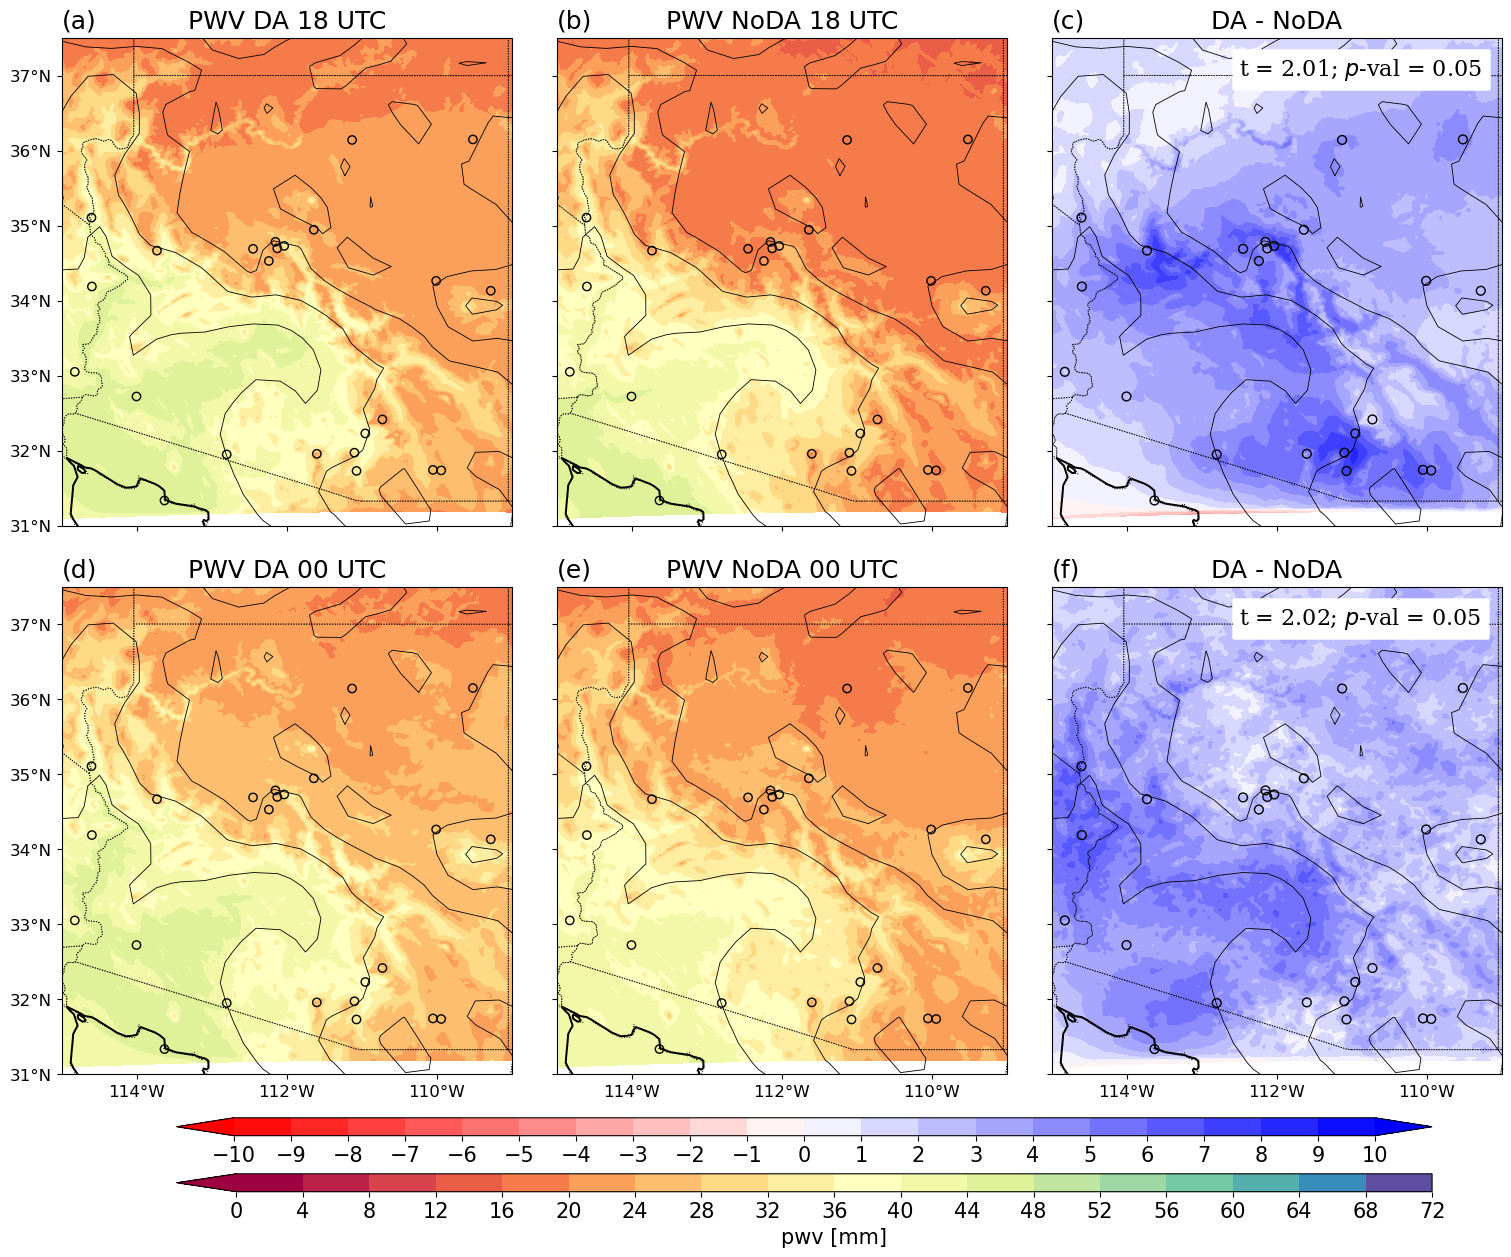

In [13]:
###########################################
# Plot #           
###########################################
projection = ccrs.PlateCarree()
fig, axe = plt.subplots(2, 3, figsize=(18, 16),
                                   subplot_kw={'projection': projection})
## AX1
axlist = axe.flatten()
for ax1 in axlist:
    plot_background(ax1)
    p0 = axlist[0].contourf(xlon,xlat,mPWV_DA[0,:,:],
                           var_pwv,cmap=PWVcol,norm=pwv_norm,extend='min',transform=projection,) 
    p1 = axlist[1].contourf(xlon,xlat,mPWV_NO[0,:,:],
                           var_pwv,cmap=PWVcol,norm=pwv_norm,extend='min',transform=projection,)
    p2 = axlist[2].contourf(xlon,xlat,mDIF[0,:,:],
                           var_diff,cmap='bwr_r',extend='both',transform=projection,)
    p3 = axlist[3].contourf(xlon,xlat,mPWV_DA[1,:,:],
                           var_pwv,cmap=PWVcol,norm=pwv_norm,extend='min',transform=projection,) 
    p4 = axlist[4].contourf(xlon,xlat,mPWV_NO[1,:,:],
                           var_pwv,cmap=PWVcol,norm=pwv_norm,extend='min',transform=projection,)
    p5 = axlist[5].contourf(xlon,xlat,mDIF[1,:,:],
                           var_diff,cmap='bwr_r',extend='both',transform=projection,)
    
    axlist[1].set_yticklabels([]);axlist[2].set_yticklabels([])
    axlist[4].set_yticklabels([]);axlist[5].set_yticklabels([])
    axlist[0].set_xticklabels([]);axlist[1].set_xticklabels([]);axlist[2].set_xticklabels([])
    
    ## set title
    t0 = axlist[0].set_title('PWV DA '+str(hor[0]).zfill(2)+' UTC',
                            loc='center',pad=7,fontsize=18)
    t0 = axlist[0].set_title('(a)',loc='left',pad=7,fontsize=18)
    t1 = axlist[1].set_title('PWV NoDA '+str(hor[0]).zfill(2)+' UTC',
                            loc='center',pad=7,fontsize=18)
    t1 = axlist[1].set_title('(b)',loc='left',pad=7,fontsize=18)
    t2 = axlist[2].set_title('DA - NoDA',
                            loc='center',pad=7,fontsize=18)
    t2 = axlist[2].set_title('(c)',loc='left',pad=7,fontsize=18)
    t3 = axlist[3].set_title('PWV DA '+str(hor[1]).zfill(2)+' UTC',
                            loc='center',pad=7,fontsize=18)
    t3 = axlist[3].set_title('(d)',loc='left',pad=7,fontsize=18)
    t4 = axlist[4].set_title('PWV NoDA '+str(hor[1]).zfill(2)+' UTC',
                            loc='center',pad=7,fontsize=18)
    t4 = axlist[4].set_title('(e)',loc='left',pad=7,fontsize=18)
    t5 = axlist[5].set_title('DA - NoDA',
                            loc='center',pad=7,fontsize=18)
    t5 = axlist[5].set_title('(f)',loc='left',pad=7,fontsize=18)

    axlist[2].annotate('t = '+ttest0+ '; $p$-val = '+pval0,(-112.5,37.0),fontsize=16, fontname='serif',
            bbox=dict(boxstyle='square',fc='w',ec='w'))
    axlist[5].annotate('t = '+ttest1+ '; $p$-val = '+pval1,(-112.5,37.0),fontsize=16, fontname='serif',
            bbox=dict(boxstyle='square',fc='w',ec='w'))
        
    ## obs
    s0 = axlist[0].scatter(Olon,Olat,c=pwv_obs,cmap=PWVcol,norm=pwv_norm,edgecolor='k')
    s0.set_facecolor('none')
    s1 = axlist[1].scatter(Olon,Olat,c=pwv_obs,cmap=PWVcol,norm=pwv_norm,edgecolor='k')
    s1.set_facecolor('none')
    s2 = axlist[2].scatter(Olon,Olat,s=40,edgecolor='k')
    s2.set_facecolor('none')
    s3 = axlist[3].scatter(Olon,Olat,c=pwv_obs,cmap=PWVcol,norm=pwv_norm,edgecolor='k')
    s3.set_facecolor('none')
    s4 = axlist[4].scatter(Olon,Olat,c=pwv_obs,cmap=PWVcol,norm=pwv_norm,edgecolor='k')
    s4.set_facecolor('none')
    s5 = axlist[5].scatter(Olon,Olat,s=40,edgecolor='k')
    s5.set_facecolor('none')
    
#Add precip colorbar
cbar0 = fig.colorbar(p0,ticks=var_pwv,ax=axe,orientation='horizontal',
                    shrink=0.9,aspect=70,pad=0.01,anchor=(0.5,-0.8))
cbar0.ax.tick_params(labelsize=15)
cbar0.set_label('pwv [mm]',fontsize=15)

cbar1 = fig.colorbar(p2,ticks=var_diff,ax=axe,orientation='horizontal',
                    shrink=0.9,aspect=70,pad=0.01,anchor=(0.5,-2.0))
cbar1.ax.tick_params(labelsize=15)

#fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace= -0.25)

## SAVE
dir_out = '/secchi/bayu/PLOTS/ARIZONA_PRO/PWV/'
plotfile  = 'MEAN_PWV-18-00_DA-NODA-diff_UTC.png'
sf = fig.savefig(dir_out+plotfile, dpi=300, bbox_inches='tight')

## CLOSE
plt.show()
plt.close()